# Calculating the FIM Matrix

This notebook calculates the FIM matrix for a small MLP after learning the toy dataset.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import pickle

from utils import mlp,train_test_model
from utils.ewc_utils.ToyExampleEWC import FullEWC, LowRankEWC, MinorDiagonalEWC, BlockDiagonalEWC
from utils.ewc_utils.ToyExampleEWC import SketchEWC

from data.sequential_lines import Lines

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
## Get Configurations

n_samples=1000
epochs = 200
lr = 1e-3
batch_size = 100
input_size = 2
hidden_sizes = [128,64]
output_size = 2

seed = 2

num_task = 4

activation='ReLU'
slope=.1
device='cuda:0'

ewc_alpha=0.5

gain={
    'Sigmoid':1.,
    'TanH':1.,
    'ReLU':np.sqrt(2.),
    'leakyReLU':np.sqrt(2./(1.+slope**2))
}

In [3]:
def weights_init(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):        
        torch.nn.init.xavier_uniform_(m.weight,gain=gain[activation])
        if m.bias: 
            torch.nn.init.xavier_uniform_(m.bias,gain=gain[activation])

In [4]:
## Load Dataset

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
datagen = Lines(max_iter=num_task, num_samples=n_samples)
train_loader,test_loader=datagen.get_full_lines(batch_size=batch_size)

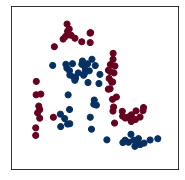

In [5]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
iter_data=iter(train_loader)
sample,label=iter_data.next()
ax.scatter(sample[:,0],sample[:,1],c=label,cmap='RdBu')
ax.set_xlim([-0.5,2.5])
ax.set_ylim([-0.75,1.25])
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [6]:
X,Y=torch.meshgrid(torch.linspace(-0.5,2.5,150),torch.linspace(-0.75,1.25,100))
grid=torch.stack([X.reshape(-1),Y.reshape(-1)]).T

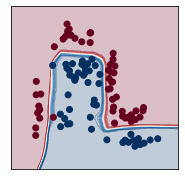

In [7]:
full_ewc_importance=1e+5

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              require_bias=True,device=device).to(device)
# model.apply(weights_init)
full_ewc= FullEWC(model,device=device,alpha=ewc_alpha)

# fig, ax=plt.subplots(1,num_task,figsize=(3*num_task,3))

## performing training
for _ in tqdm(range(epochs)):
    model.train()
    optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
    train_test_model.train_classifier(model=model,
                                      optimizer=optimizer,
                                      data_loader=train_loader,
                                      device=device)          

plt.figure(figsize=(3,3))
# Plot decision boundary
pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(150,100).detach().cpu().numpy()
plt.contourf(X, Y, pred,cmap='RdBu', alpha=0.25,levels=50)
# Plot data
plt.scatter(sample[:,0],sample[:,1],c=label,cmap='RdBu')
plt.xlim([-0.5,2.5])
plt.ylim([-0.75,1.25])
plt.xticks([])
plt.yticks([])
#     if save_plot: plt.savefig("figure/toy_mlp_task_%d.pdf"%(task+1), bbox_inches='tight')
#     plt.show()      
# plt.savefig("figure/toy_full_ewc.pdf", bbox_inches='tight')
plt.show()   


In [8]:
fim=full_ewc.calculate_FIM(train_loader).to('cpu')

In [9]:
q=np.quantile(abs(fim).reshape(-1),np.linspace(0.75,1,10))
print(q)

[0.00000000e+00 2.71734454e-32 2.54078403e-09 3.35908837e-07
 2.46495593e-06 7.81945012e-06 2.07673520e-05 5.07815821e-05
 1.39287135e-04 9.83599424e-01]


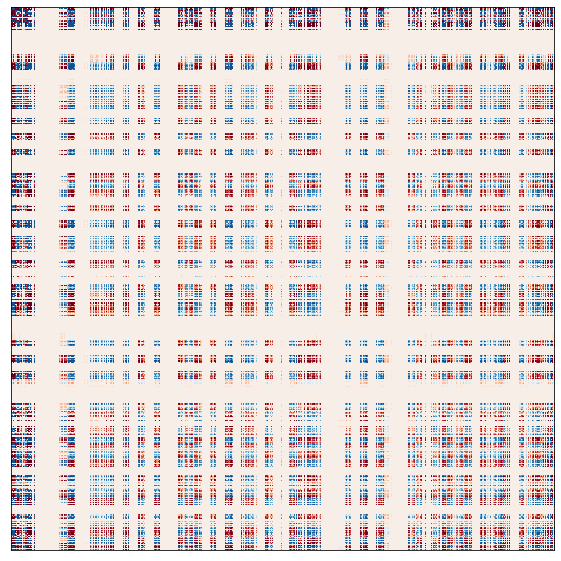

In [73]:
# B=full_ewc.calculate_FIM(train_loader[task]).to('cpu')
# vis_thresh=1e-5
# B=np.sign(B)*(abs(B)>vis_thresh)
# B=np.sign(B)*(np.log10((1e-15)+abs(B)))
# B=(np.log10((1e-15)+abs(B)))
# q=np.quantile(abs(B).reshape(-1),np.linspace(0.2,.8,5))
# B=np.argmin(abs(B.reshape(-1)[:,np.newaxis]-q[np.newaxis,:]),1).reshape(B.shape[0],B.shape[1])
# q=np.quantile(abs(fim).reshape(-1),np.linspace(0.8,1,10))
B=np.sign(fim)*np.argmin(abs(abs(fim).reshape(-1)[:,np.newaxis]-q[np.newaxis,:]),1).reshape(fim.shape[0],fim.shape[1])/10
# B=np.argmin(abs(abs(B).reshape(-1)[:,np.newaxis]-q[np.newaxis,:]),1).reshape(B.shape[0],B.shape[1])

fig=plt.figure(figsize=(10,10))
osetx=0
osety=osetx
plt.xticks([])
plt.yticks([])
plt.imshow(B[osetx:-1,osety:-1],cmap='RdBu')
# cb=plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig("figure/toy_fim_illustration.pdf", bbox_inches='tight')

In [11]:
print(((fim-np.diag(np.diag(fim)))**2).sum()/(fim**2).sum())

tensor(0.9487)


In [12]:
u, s, v =torch.svd_lowrank(fim, q=1)
rank_1_approx = torch.mm(torch.mm(u, torch.diag(s)), v.t())
print(((fim-rank_1_approx)**2).sum()/(fim**2).sum())

tensor(0.0566)


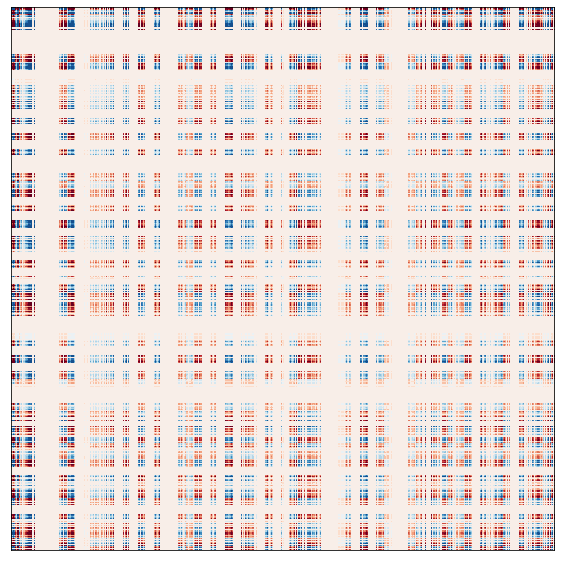

In [13]:
B=np.sign(rank_1_approx)*np.argmin(abs(abs(rank_1_approx).reshape(-1)[:,np.newaxis]-q[np.newaxis,:]),1).reshape(rank_1_approx.shape[0],fim.shape[1])

fig=plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(B[0:-1,0:-1],cmap='RdBu')

In [14]:
u, s, v =torch.svd_lowrank(fim, q=50)
low_rank_approx = torch.mm(torch.mm(u, torch.diag(s)), v.t())
print(((fim-low_rank_approx)**2).sum()/(fim**2).sum())

tensor(1.4791e-11)


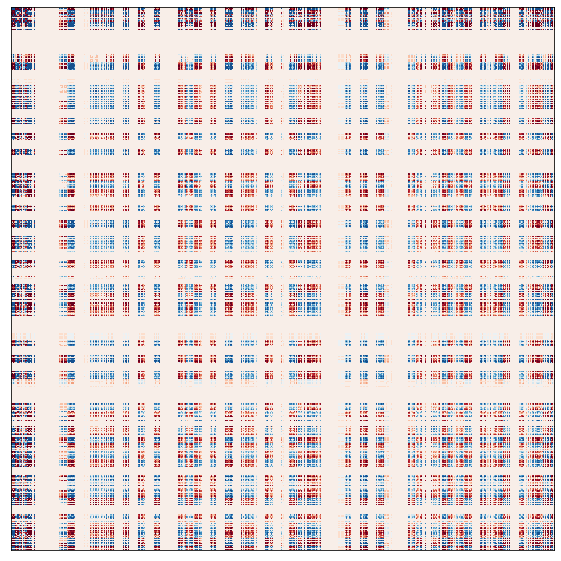

In [15]:
B=np.sign(low_rank_approx)*np.argmin(abs(abs(low_rank_approx).reshape(-1)[:,np.newaxis]-q[np.newaxis,:]),1).reshape(low_rank_approx.shape[0],fim.shape[1])

fig=plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(B[0:-1,0:-1],cmap='RdBu')

In [16]:
n_bucket=51
deviation = int((n_bucket-1)/2)
minor_diagonal_approx = torch.triu(fim, diagonal=(-deviation)) - torch.triu(fim, diagonal=(n_bucket-deviation))
print(((fim-minor_diagonal_approx)**2).sum()/(fim**2).sum())

tensor(0.8292)


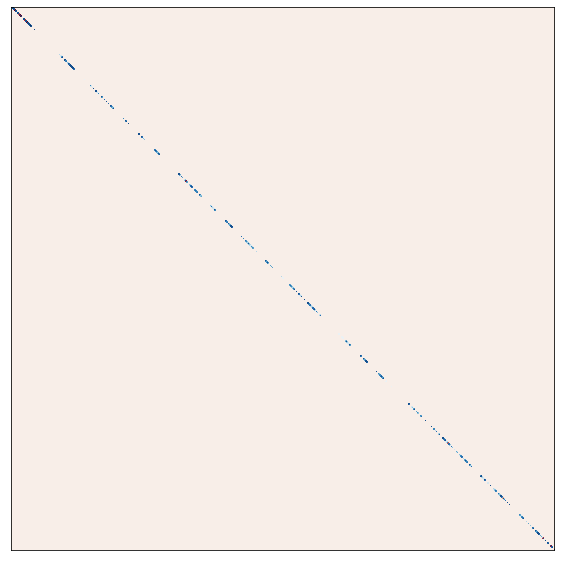

In [17]:
B=np.sign(minor_diagonal_approx)*np.argmin(abs(abs(minor_diagonal_approx).reshape(-1)[:,np.newaxis]-q[np.newaxis,:]),1).reshape(minor_diagonal_approx.shape[0],fim.shape[1])

fig=plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(B[0:-1,0:-1],cmap='RdBu')

In [74]:
error=[]
for sketch_seed in range(10):
    random.seed(sketch_seed)
    np.random.seed(sketch_seed)
    torch.manual_seed(sketch_seed)

    sketch_ewc = SketchEWC(model,device=device,alpha=ewc_alpha,n_sketch=50)
    sketched_fim = sketch_ewc.calculate_approximation(train_loader).to('cpu')
    error.append(((fim-sketched_fim)**2).sum()/(fim**2).sum())
print(sum(error)/len(error))

tensor(0.0557)


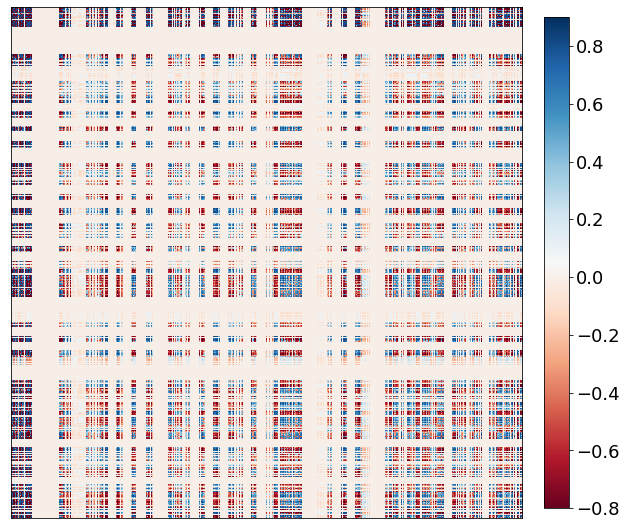

In [82]:
B=np.sign(sketched_fim)*np.argmin(abs(abs(sketched_fim).reshape(-1)[:,np.newaxis]-q[np.newaxis,:]),1).reshape(sketched_fim.shape[0],fim.shape[1])/10

fig=plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(B[0:-1,0:-1],cmap='RdBu')
cb=plt.colorbar(fraction=0.044, pad=0.04)
# cb.set_ticks([])
cb.ax.tick_params(labelsize=18)
plt.savefig("figure/toy_sketched_fim_illustration.pdf", bbox_inches='tight')

In [20]:
block_diagonal_ewc = BlockDiagonalEWC(model,device=device,alpha=ewc_alpha, n_bucket=50)
block_diagonal_fim = block_diagonal_ewc.calculate_approximation(train_loader).to('cpu')
print(((fim-block_diagonal_fim)**2).sum()/(fim**2).sum())

tensor(0.8285)


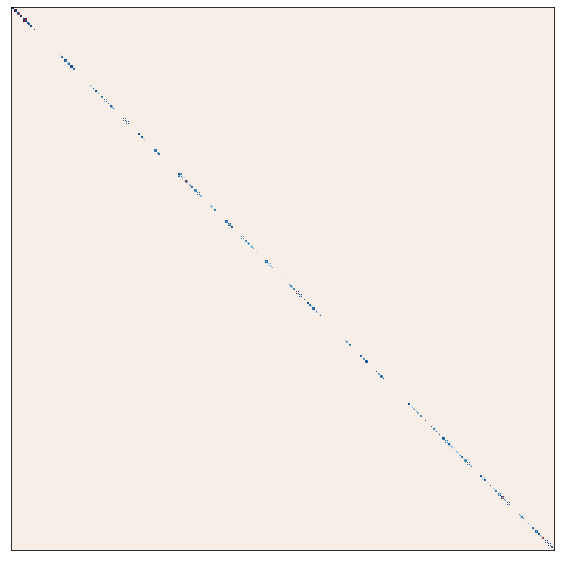

In [21]:
B=np.sign(block_diagonal_fim)*np.argmin(abs(abs(block_diagonal_fim).reshape(-1)[:,np.newaxis]-q[np.newaxis,:]),1).reshape(block_diagonal_fim.shape[0],fim.shape[1])

fig=plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(B[0:-1,0:-1],cmap='RdBu')

In [54]:
from scipy.linalg import svd

In [55]:
_,s,_ = svd(fim)
print(s)

[1.2447488e+01 2.8936875e+00 7.1590436e-01 ... 3.9699256e-07 2.3943369e-07
 6.0848208e-08]


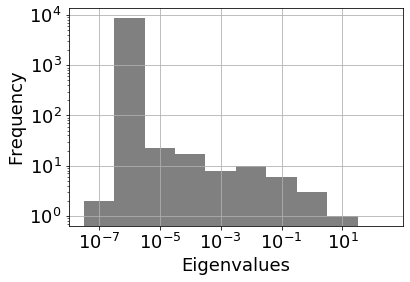

In [59]:
# plt.figure(figsize=(8,5))
# plt.bar(range(len(svd.singular_values_[:10])), svd.singular_values_[:10])
# plt.xticks(fontsize=18),plt.yticks(fontsize=18)
# plt.ylabel('Singular Value',fontsize=18)

logbins = [3.16 * 10 ** i for i in range(-8,3)]
plt.hist(s, bins=logbins,color='grey')
plt.xscale('log'),plt.yscale('log')
plt.xticks(fontsize=18),plt.yticks(fontsize=18)
plt.xlabel('Eigenvalues',fontsize=18),plt.ylabel('Frequency',fontsize=18)
plt.grid()
plt.savefig("figure/toy_fim_spectrum.pdf", bbox_inches='tight')

In [25]:
print(fim.shape)

torch.Size([8770, 8770])
